Set float to float64
Compiling model...
Building feed-forward neural network...


/home/yangsam/.local/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/yangsam/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/home/yangsam/.local/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:268: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  warnings.warn('`tf.layers.dropout` is deprecated and '


'build' took 0.279805 s

'compile' took 6.097919 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [4.00e-03, 8.10e-03, 2.93e-03, 8.30e-01, 8.06e-06, 5.59e-02, 2.96e-02, 2.58e-04]    [3.50e-03, 7.70e-03, 2.65e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [2.53e-03, 5.52e-03, 3.48e-03, 1.92e-03, 5.99e-05, 1.42e-06, 4.33e-05, 3.04e-03]    [1.71e-03, 2.67e-03, 2.20e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [1.98e-03, 4.11e-03, 3.31e-03, 1.19e-03, 2.57e-05, 1.59e-06, 4.61e-05, 2.21e-03]    [1.15e-03, 2.34e-03, 1.88e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [1.72e-03, 2.72e-03, 3.27e-03, 9.23e-04, 3.62e-05, 6.13e-06, 9.62e-05, 1.43e-03]    [7.86e-04, 1.79e-03, 1.97e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,

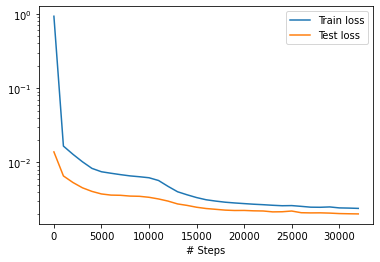

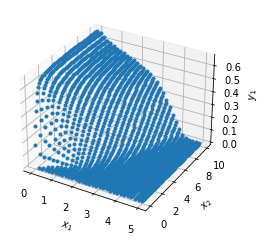

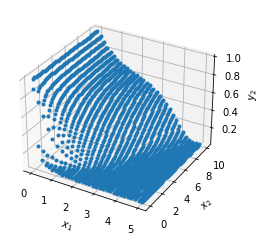

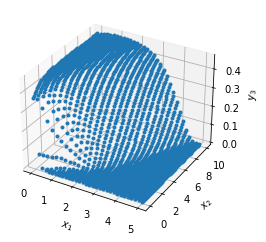

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tensorflow.keras.backend import set_floatx
import time
import deepxde as dde
import tensorflow as tf
import numpy as np
import os

dde.config.real.set_float64()

def main():

    L = 5.
    tend = 10.

    def HX(x, y):
        R = 1
        Vc = 1
        Vh = 1
        
        theta_w, theta_h, theta_c = y[:, 0:1], y[:, 1:2], y[:, 2:3]

        dtheta_w = tf.gradients(theta_w, x)[0]
        dtheta_h = tf.gradients(theta_h, x)[0]
        dtheta_c = tf.gradients(theta_c, x)[0]

        dtheta_w_t = dtheta_w[:,1:2]
        dtheta_h_x, dtheta_h_t = dtheta_h[:,0:1], dtheta_h[:,1:2]
        dtheta_c_x, dtheta_c_t = dtheta_c[:,0:1], dtheta_c[:,1:2]
        
        eq_w = dtheta_w_t - theta_c - R*theta_h + (1+R)*theta_w 
        eq_h = dtheta_h_t - R/Vh*(theta_w - theta_h - dtheta_h_x)
        eq_c = dtheta_c_t - 1/Vc*(theta_w - theta_c - dtheta_c_x)

        return [ eq_w, eq_h, eq_c ]

    def bc_inlet(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0)

    def bc_outlet(x, on_boundary):
        return on_boundary and np.isclose(x[0], L)

    def inlet(x):
        # return 1.-np.sin(-0.5*x[:, 1:])
        return 1.

    geom = dde.geometry.Interval(0, L)
    timedomain = dde.geometry.TimeDomain(0, tend)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    h_inlet = dde.DirichletBC(geomtime, inlet, bc_inlet, component=1)
    h_outlet = dde.NeumannBC(geomtime, lambda x: 0, bc_outlet, component=1)
    c_inlet = dde.DirichletBC(geomtime, lambda x: 0, bc_outlet, component=2)
    c_outlet = dde.NeumannBC(geomtime, lambda x: 0, bc_inlet, component=2)
    ic = dde.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime, HX,
        [ h_inlet, h_outlet, 
        c_inlet, c_outlet, 
        ic ], 
        num_domain=20000, num_boundary=10000, num_initial=1000, num_test=2000,
    )
    layer_size = [2] + [20] * 16 + [3]
    activation = "tanh"
    initializer = "Glorot uniform"
    # net = dde.maps.FNN(layer_size, activation, initializer)
#     net = dde.maps.ResNet(2,3,20,16, activation, initializer)
    net = dde.maps.PFNN(layer_size, activation, initializer, dropout_rate=0.05)
    model = dde.Model(data, net)
    model.compile( "adam", lr=1e-4,loss_weights=[0.1,0.1,0.1,1,1,1,1,1] ) 
    
    earlystop = dde.callbacks.EarlyStopping(
        min_delta = 1e-4, patience = 5000
    )
    # variable = dde.callbacks.VariableValue(C, period = 500, filename="variables.dat")
    losshistory, train_state = model.train(epochs = 50000, callbacks=[earlystop],display_every = 1000, uncertainty = False, batch_size = 100 )#, callbacks=[checkpointer])
    dde.saveplot(losshistory, train_state, issave = True, isplot=True) 
    
if __name__ == "__main__":
    main()

   


0.006306768061084775
0.04954301999790513


Text(0.5, 1.0, '$|\\theta_{c,exact}-\\theta_{c,PINN}|$')

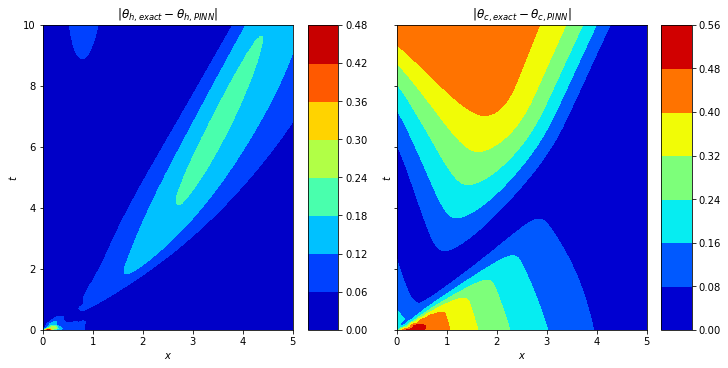

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import griddata
import numpy as np
from sklearn.metrics import mean_squared_error as mse

# create a grid for interpolation & comparison
grid_x, grid_t = np.mgrid[0:5:100j, 0:10:200j]
interp = 'cubic'

# x = np.sort(exact.x.unique())
# t = np.sort(exact.t.unique())
# # x, t = np.meshgrid(x, t)
# true_theta_h = pd.DataFrame(exact.pivot_table(index='x', columns='t', values='theta_h').T.values).round(iround)
# true_theta_c = pd.DataFrame(exact.pivot_table(index='x', columns='t', values='theta_c').T.values).round(iround)

# exact solution
exact = pd.read_csv('sol_true.dat',delim_whitespace=True, skiprows=0, header=None) 
exact.columns = ["x", "t", "theta_w", "theta_h", 'theta_c']
exact.theta_c = exact.theta_c.values[::-1]
x = exact.x.values
t = exact.t.values
exact_theta_h = exact.theta_h.values
exact_theta_c = exact.theta_c.values
exact_theta_h = griddata(np.vstack((x,t)).T, exact_theta_h, (grid_x, grid_t), method=interp)
exact_theta_c = griddata(np.vstack((x,t)).T, exact_theta_c, (grid_x, grid_t), method=interp)

# PINN solution
pred = pd.read_csv('test.dat',delim_whitespace=True, skiprows=1, header=None) 
pred.columns = ["x", "t", "theta_w", "theta_h", 'theta_c']
x = pred.x.values
t = pred.t.values
pred_theta_h = pred.theta_h.values
pred_theta_c = pred.theta_c.values
pred_theta_h = griddata(np.vstack((x,t)).T, pred_theta_h, (grid_x, grid_t), method=interp)
pred_theta_c = griddata(np.vstack((x,t)).T, pred_theta_c, (grid_x, grid_t), method=interp)

print(mse(exact_theta_h,pred_theta_h))
print(mse(exact_theta_c,pred_theta_c))

# Initialize plot objects
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, constrained_layout = True, figsize=(10,5))

# Generate contour plots for absolute errors
plt.axes(ax1)
plt.contourf(grid_x,grid_t,abs(pred_theta_h-exact_theta_h), origin='lower', cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'$|\theta_{h,exact}-\theta_{h,PINN}|$')

plt.axes(ax2)
plt.contourf(grid_x,grid_t,abs(pred_theta_c-exact_theta_c), origin='lower', cmap='jet')
plt.colorbar()
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'$|\theta_{c,exact}-\theta_{c,PINN}|$')


